In [3]:
import numpy as np
import pandas as pd

import os
import seaborn as sns

import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.applications import Xception
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D
from keras.optimizers import Adam,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model,Sequential
from tensorflow.keras.layers import Input

# Hyperparamètres du Modèle

- `IMAGE_SIZE = 80` : Taille de chaque image redimensionnée (80x80 pixels).
- `COLORS = 3` : Nombre de canaux de couleur dans chaque image (3 pour RGB).
- `BATCH_SIZE = 64` : Nombre d'images dans chaque lot d'entraînement.
- `RANDOM_STATE = 42` : Graine aléatoire pour garantir la reproductibilité (données divisées de manière ientique à chaque exécution) des partitions de données.

In [4]:
IMAGE_SIZE = 80
COLORS=3
BATCH_SIZE = 64
RANDOM_STATE=42

- `classification_types`: Liste des types de maladies et d'états de santé des plantes.
- `data_dir = 'PlantVillage/'`: Chemin vers le répertoire de données d'images.
- `train_dir`: Chemin d'entraînement basé sur `data_dir` donc sur PlantVillage.

In [5]:
classification_types=['Pepper__bell___Bacterial_spot','Pepper__bell___healthy',
                      'Potato___Early_blight','Potato___Late_blight','Potato___healthy',
                      'Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight',
                      'Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot',
                      'Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot',
                      'Tomato__Tomato_YellowLeaf__Curl_Virus',
                      'Tomato__Tomato_mosaic_virus','Tomato_healthy']
data_dir = 'PlantVillage/'
train_dir = os.path.join(data_dir)
print(train_dir)

PlantVillage/


- Boucle sur `classification_types` pour créer `train_data`, une liste contenant les informations sur chaque image :
  - `File` : Nom du fichier.
  - `DiseaseID` : Identifiant de la maladie.
  - `Disease_Type` : Type de maladie.
  - `File_Path` : Chemin complet du fichier.
- `train` : DataFrame avec les colonnes `File`, `DiseaseID`, `Disease_Type`, et `File_Path`.
- `train.head()` : Affiche les premières lignes de `train`.

In [6]:
train_data=[]
for id, disease in enumerate(classification_types):
    dir = os.path.join(data_dir,disease)
    for file in os.listdir(dir):
        train_data.append([os.path.join(disease,file),id,disease,os.path.join(dir,file)])


train = pd.DataFrame(train_data,columns=['Fichier','ID des maladies','Type de maladie','Chemin du fichier'])
train.head()

,Fichier,ID des maladies,Type de maladie,Chemin du fichier
0,Pepper__bell___Bacterial_spot\0022d6b7-d47c-4e...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\002...
1,Pepper__bell___Bacterial_spot\006adb74-934f-44...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\006...
2,Pepper__bell___Bacterial_spot\00f2e69a-1e56-41...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\00f...
3,Pepper__bell___Bacterial_spot\01613cd0-d3cd-4e...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\016...
4,Pepper__bell___Bacterial_spot\0169b9ac-07b9-4b...,0,Pepper__bell___Bacterial_spot,PlantVillage/Pepper__bell___Bacterial_spot\016...


- `train.sample(frac=1, random_state=RANDOM_STATE)`: Mélange aléatoirement les données en utilisant la graine `RANDOM_STATE`.
- `train.reset_index(drop=True, inplace=True)`: Réinitialise les index du DataFrame après le mélange.
- `train.head()`: Affiche les premières lignes du DataFrame mélangé.

In [7]:
train = train.sample(frac=1,random_state=RANDOM_STATE)
train.reset_index(drop=True, inplace=True)
train.head()

,Fichier,ID des maladies,Type de maladie,Chemin du fichier
0,Tomato_healthy\9d197d8a-3f35-401a-8aa4-39f7e69...,14,Tomato_healthy,PlantVillage/Tomato_healthy\9d197d8a-3f35-401a...
1,Potato___Early_blight\900514b4-8768-4370-bc53-...,2,Potato___Early_blight,PlantVillage/Potato___Early_blight\900514b4-87...
2,Tomato_Septoria_leaf_spot\dc5f2f7d-8b86-402e-8...,9,Tomato_Septoria_leaf_spot,PlantVillage/Tomato_Septoria_leaf_spot\dc5f2f7...
3,Tomato_healthy\e3b5600f-9c88-4060-826f-aa7c972...,14,Tomato_healthy,PlantVillage/Tomato_healthy\e3b5600f-9c88-4060...
4,Tomato_Leaf_Mold\2e84cbfc-af2c-4c2b-9273-84275...,8,Tomato_Leaf_Mold,PlantVillage/Tomato_Leaf_Mold\2e84cbfc-af2c-4c...


- `display_random_images(rows, cols)`: Fonction qui affiche des images aléatoires du DataFrame `train`.
  - `rows` et `cols` définissent la disposition des images.
  - Sélectionne aléatoirement `rows * cols` images de `train`.
  - Affiche chaque image dans un subplot `rows x cols`.
- `display_random_images(3, 5)`: Affiche 15 images aléatoires (3 lignes et 5 colonnes).

In [10]:
print(train.columns)


Index(['Fichier', 'ID des maladies', 'Type de maladie', 'Chemin du fichier'], dtype='object')


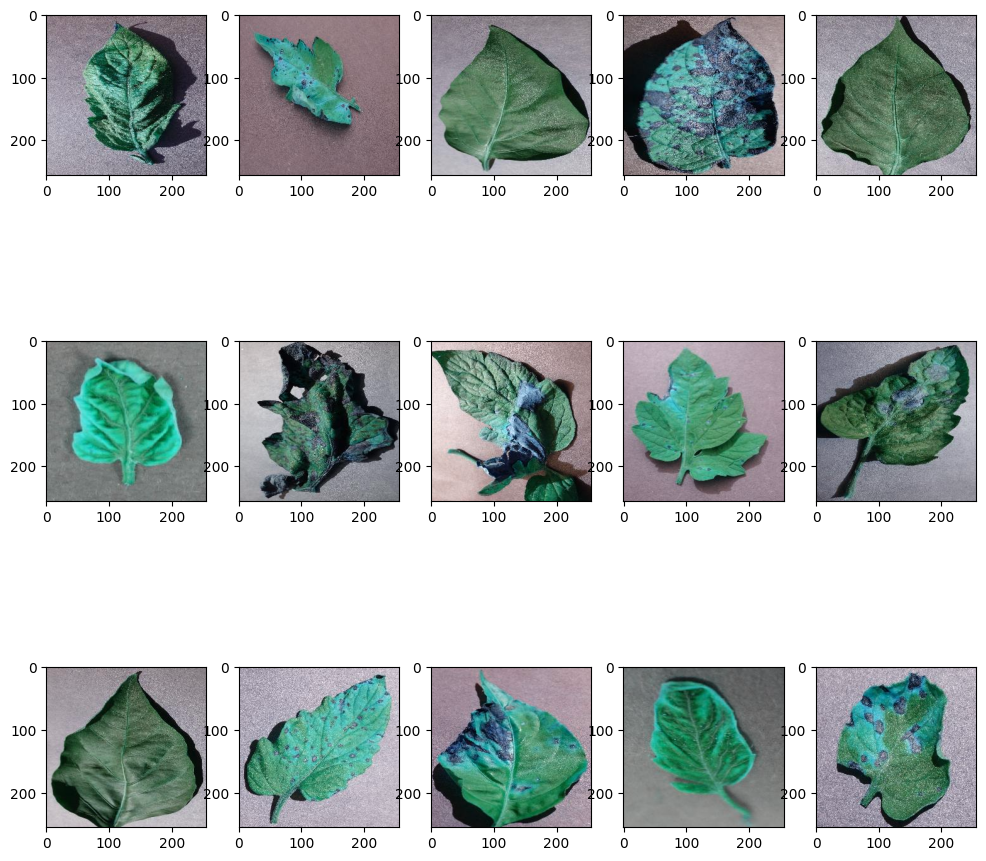

In [11]:
def display_random_images(rows,cols):
    fig, ax = plt.subplots(rows,cols,figsize=(12,12))
    random = train.sample(rows*cols)

    for i in range(rows):
        for j in range(cols):
            image_path=os.path.join(data_dir,random.iloc[i*cols+j]['Fichier'])
            ax[i,j].imshow(cv2.imread(image_path))

display_random_images(3,5)

- `get_training_data()`: Fonction qui charge et redimensionne les images de `train` :
  - Crée un tableau `data` avec des images redimensionnées à la taille `IMAGE_SIZE x IMAGE_SIZE`.
  - Chaque image est lue, redimensionnée et normalisée (valeurs entre 0 et 1).
- `X = get_training_data()`: Appelle la fonction pour obtenir les données d'entraînement sous forme de tableau `X`.

In [13]:
def get_training_data():
    data = np.zeros((train.shape[0],IMAGE_SIZE,IMAGE_SIZE,COLORS))
    for i, file in tqdm(enumerate(train['Fichier'].values)):
        img = cv2.imread(os.path.join(data_dir,file))
        if img is not None:
            img_resized = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE),interpolation=cv2.INTER_AREA)
            img_resized = img_resized/255
            data[i]=img_resized
    return data

X = get_training_data()

20639it [00:50, 406.64it/s]


- `y = to_categorical(train['DiseaseID'], num_classes=np.unique(train['DiseaseID']).size)`: Convertit les labels `DiseaseID` en vecteurs one-hot (ces de l'encodage binaire) pour chaque classe. Cela va permettre de représenter chaque catégorie indépendamment des autres afin d'éviter l'ambiguité lié à l'inteprétation 
- `print(y.shape)`: Affiche la forme du tableau `y` (dimensions du tableau des labels).

In [16]:
y = to_categorical(train['ID des maladies'],num_classes=np.unique(train['ID des maladies']).size)
print(y.shape)

(20639, 15)


- `image_dataset_from_dataframe(df, image_column, label_column, **kwargs)`: Fonction pour créer un jeu de données TensorFlow à partir d'un DataFrame.
  - `decode_image(path, label)`: Fonction interne pour lire et décoder les images, puis les redimensionner à `IMAGE_SIZE x IMAGE_SIZE`.
  - `dataset`: Crée un objet `tf.data.Dataset` à partir des chemins d'images et des labels.
  - `dataset.map()`: Applique la fonction de décodage sur chaque image.
  - `dataset.batch()`: Regroupe les données en lots (taille par défaut 32).

In [17]:
def image_dataset_from_dataframe(df, image_column, label_column, **kwargs):
    def decode_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
        return image, label
    paths = df[image_column].values
    labels = df[label_column].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(kwargs.get('batch_size', 32))
    return dataset

- `train_ds = image_dataset_from_dataframe(train, 'File_Path', 'Disease_Type', batch_size=32)`: Crée un jeu de données d'entraînement à partir du DataFrame `train` en utilisant les colonnes `File_Path` pour les images et `Disease_Type` pour les labels. Les images sont chargées par lots de taille 32.
  
- `validation_ds = tf.keras.utils.image_dataset_from_directory(...)`: Crée un jeu de données de validation en chargeant les images depuis un répertoire (`data_dir`) et en les divisant en sous-ensembles d'entraînement et de validation avec `validation_split=0.1` (10% pour la validation). Les images sont redimensionnées à `IMAGE_SIZE` et chargées par lots de taille 32.

In [20]:
train_ds = image_dataset_from_dataframe(train,'Chemin du fichier','Type de maladie',batch_size=32)
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Found 41276 files belonging to 16 classes.
Using 4127 files for validation.


- `X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)`: Divise les données en ensembles d'entraînement et de validation :
  - `X_train` et `y_train` pour l'entraînement (80% des données).
  - `X_val` et `y_val` pour la validation (20% des données).
  - `random_state=RANDOM_STATE` assure la reproductibilité de la division des données.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=RANDOM_STATE)

- `fig, ax = plt.subplots(1, 3, figsize=(15, 15))`: Crée une figure avec 1 ligne et 3 colonnes de sous-graphes pour afficher 3 images.
- `for i in range(3)`: Boucle pour afficher 3 images.
  - `ax[i].set_axis_off()`: Masque les axes pour une meilleure présentation.
  - `ax[i].imshow(X_train[i])`: Affiche l'image à l'index `i` du tableau `X_train`.
  - `ax[i].set_title(classification_types[np.argmax(y_train[i])])`: Ajoute un titre correspondant à la classe de l'image (avec `np.argmax(y_train[i])` pour obtenir l'indice de la classe).

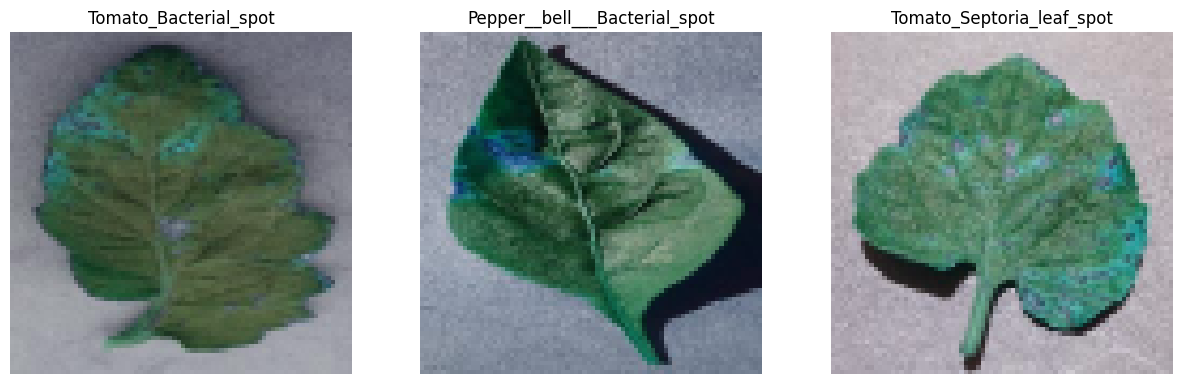

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(classification_types[np.argmax(y_train[i])])

- `datagen = ImageDataGenerator(...)`: Crée un objet `ImageDataGenerator` pour appliquer des augmentations d'images pendant l'entraînement.
  - `rotation_range=360`: Applique des rotations aléatoires dans une plage de 360°.
  - `width_shift_range=0.2`: Applique des déplacements horizontaux aléatoires dans une plage de 20% de la largeur de l'image.
  - `height_shift_range=0.2`: Applique des déplacements verticaux aléatoires dans une plage de 20% de la hauteur de l'image.
  - `zoom_range=0.2`: Applique un zoom aléatoire dans une plage de 20%.
  - `horizontal_flip=True`: Effectue un retournement horizontal aléatoire des images.
  - `vertical_flip=True`: Effectue un retournement vertical aléatoire des images.
  
- `datagen.fit(X_train)`: Applique l'augmentation d'images aux données d'entraînement `X_train`.

In [23]:
datagen = ImageDataGenerator(rotation_range=360,
                        width_shift_range=0.2,
                        height_shift_range=0.2, 
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True)
datagen.fit(X_train)

- `base_model = Xception(...)`: Charge le modèle pré-entraîné Xception avec les paramètres suivants :
  - `weights='imagenet'`: Utilise les poids pré-entraînés sur le dataset ImageNet.
  - `include_top=False`: Exclut la partie supérieure du modèle (la couche de classification finale), pour l'utiliser comme extracteur de caractéristiques.
  - `pooling='avg'`: Applique un pooling moyen sur la sortie de la dernière couche convolutive.
  - `input_shape=(IMAGE_SIZE, IMAGE_SIZE, COLORS)`: Définit la forme des entrées comme étant des images de taille `IMAGE_SIZE x IMAGE_SIZE` et 3 canaux (couleurs).

- `base_model.trainable=False`: Gèle les couches du modèle de base pour qu'elles ne soient pas mises à jour pendant l'entraînement (seules les couches ajoutées seront entraînées).

In [24]:
base_model=Xception(weights='imagenet',include_top=False,pooling='avg',
                    input_shape=(IMAGE_SIZE,IMAGE_SIZE,COLORS))
base_model.trainable=False

- `model = Sequential()`: Crée un modèle séquentiel, où les couches sont empilées les unes après les autres.
  
- `model.add(base_model)`: Ajoute le modèle de base Xception (chargé précédemment) comme première couche du modèle.

- `model.add(BatchNormalization())`: Ajoute une couche de normalisation de lot pour améliorer la stabilité et accélérer l'entraînement.

- `model.add(Dropout(0.45))`: Ajoute une couche de `Dropout` avec un taux de 45% pour prévenir le surapprentissage en désactivant aléatoirement 45% des neurones pendant l'entraînement.

- `model.add(Dense(220, activation='relu'))`: Ajoute une couche dense (fully connected) avec 220 neurones et la fonction d'activation ReLU.

- `model.add(Dropout(0.45))`: Ajoute à nouveau une couche de `Dropout` avec un taux de 45%.

- `model.add(Dense(60, activation='relu'))`: Ajoute une couche dense avec 60 neurones et la fonction d'activation ReLU.

- `model.add(Dense(15, activation='softmax', name='root'))`: Ajoute une couche de sortie dense avec 15 neurones (correspondant au nombre de classes) et la fonction d'activation Softmax, qui est utilisée pour la classification multiclasse.

- `optimizer = Adam(...)`: Configure l'optimiseur Adam avec les paramètres suivants :
  - `learning_rate=0.002`: Taux d'apprentissage fixé à 0.002.
  - `beta_1=0.9`, `beta_2=0.999`: Paramètres de moment de l'optimiseur Adam.
  - `epsilon=0.1`: Epsilon pour éviter les divisions par zéro.
  - `decay=0.0`: Pas de décroissance du taux d'apprentissage.

- `model.compile(...)`: Compile le modèle avec la fonction de perte `categorical_crossentropy` pour la classification multiclasse, l'optimiseur Adam et la métrique `accuracy` pour évaluer les performances.

- `model.summary()`: Affiche un résumé du modèle, y compris la structure des couches et le nombre de paramètres.

In [25]:
model=Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(Dropout(0.45))
model.add(Dense(220,activation='relu'))
model.add(Dropout(0.45))
model.add(Dense(60,activation='relu'))
model.add(Dense(15,activation='softmax',name='root'))

optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

c:\Users\naelb\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 220)            │       450,780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 220)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        13,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ root (Dense)                    │ (None, 15)             │           915 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,334,627 (81.39 MB)

 Trainable params: 469,051 (1.79 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

- `early_stopping = EarlyStopping(...)`: Configure le mécanisme d'arrêt précoce pour prévenir le surapprentissage :
  - `monitor='val_loss'`: Surveille la perte sur les données de validation.
  - `patience=5`: Arrête l'entraînement si la perte de validation ne s'améliore pas après 5 epochs.
  - `restore_best_weights=True`: Restaure les meilleurs poids du modèle (ceux avec la perte de validation la plus basse).

- `history = model.fit(...)`: Entraîne le modèle en utilisant les données d'entraînement et de validation :
  - `X_train, y_train`: Les données d'entraînement et les étiquettes.
  - `epochs=30`: Le nombre maximum d'epochs (cycles d'entraînement).
  - `validation_data=(X_val, y_val)`: Les données de validation pour évaluer le modèle après chaque epoch.
  - `callbacks=[early_stopping]`: Utilise le callback `early_stopping` pour arrêter l'entraînement si la condition d'arrêt est remplie.

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train,y_train,
                        epochs= 30,
                        validation_data = (X_val,y_val),
                        callbacks = early_stopping)

Epoch 1/30
206/516 ━━━━━━━━━━━━━━━━━━━━ 57s 186ms/step - accuracy: 0.1322 - loss: 3.1509

### Visualisation de la précision et des pertes

Le graphique ci-dessous montre l'évolution de la **précision** et de la **perte** pendant l'entraînement et la validation, avec un marquage de l'**époque optimale**.

- **Précision d'entraînement** (en bleu) vs **Précision en validation** (en rouge).
- **Pertes d'entraînement** (en bleu) vs **Pertes de validation** (en rouge).

La **pointe verte** indique l'époque avec la meilleure précision en validation.

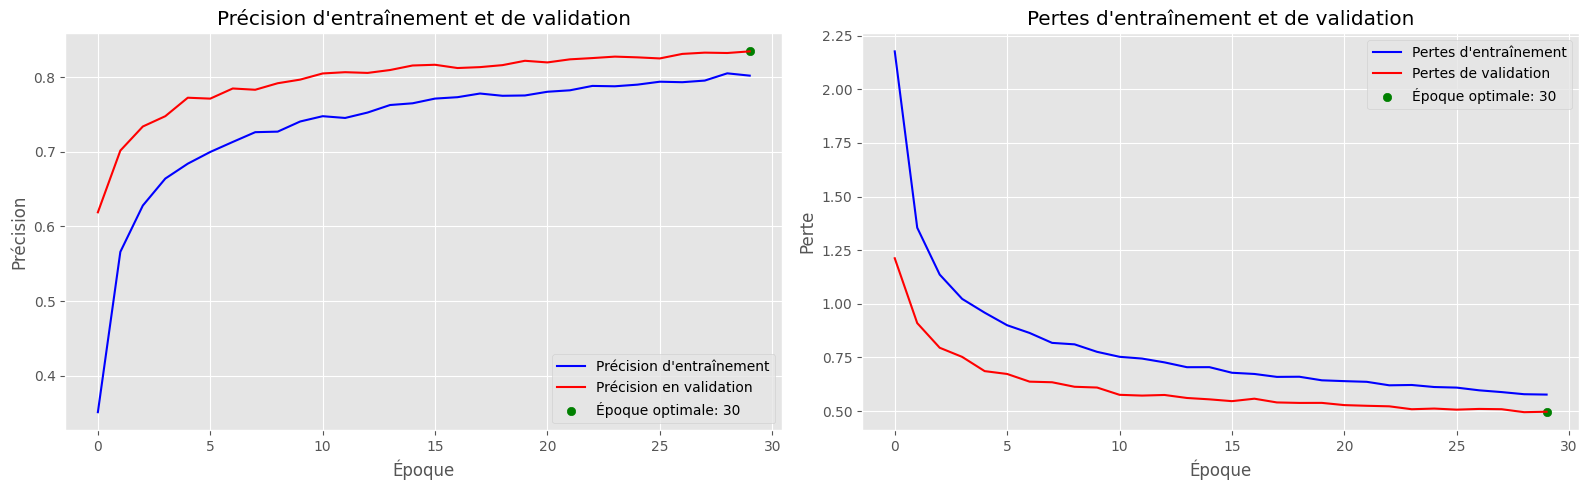

In [20]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1

plt.style.use('ggplot')

fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(history.history['accuracy'], label='Précision d\'entraînement', color='blue')
axs[0].plot(history.history['val_accuracy'], label='Précision en validation', color='red')
axs[0].scatter(best_epoch - 1, history.history['val_accuracy'][best_epoch - 1], color='green', label=f'Époque optimale: {best_epoch}')
axs[0].set_xlabel('Époque')
axs[0].set_ylabel('Précision')
axs[0].set_title('Précision d\'entraînement et de validation')
axs[0].legend()

axs[1].plot(history.history['loss'], label='Pertes d\'entraînement', color='blue')
axs[1].plot(history.history['val_loss'], label='Pertes de validation', color='red')
axs[1].scatter(best_epoch - 1, history.history['val_loss'][best_epoch - 1], color='green', label=f'Époque optimale: {best_epoch}')
axs[1].set_xlabel('Époque')
axs[1].set_ylabel('Perte')
axs[1].set_title('Pertes d\'entraînement et de validation')
axs[1].legend()

plt.tight_layout()
plt.show()


### Matrice de Confusion

Le code suivant génère une matrice de confusion afin d'évaluer la performance du modèle sur les données de validation. La matrice compare les classes réelles et prédites pour voir où le modèle se trompe et dans quelles classes.

129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 209ms/step


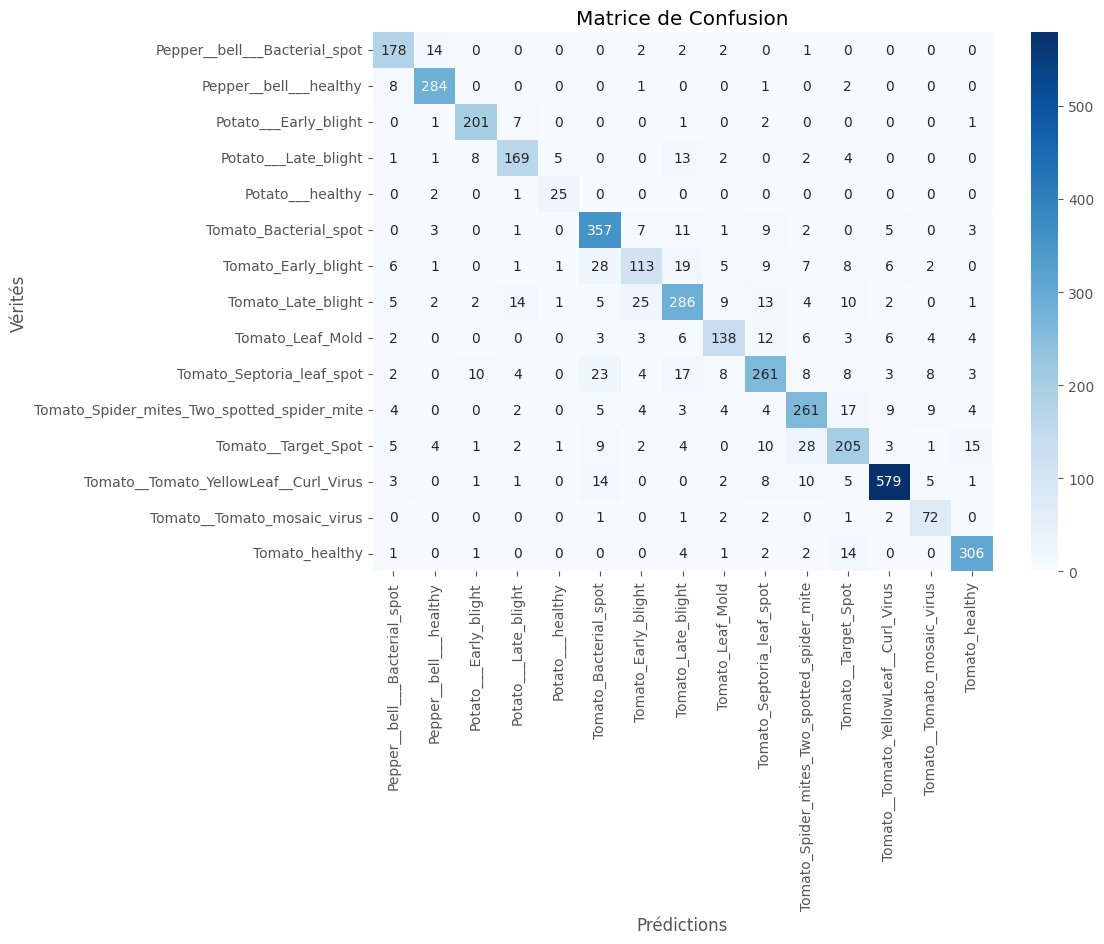

In [21]:
y_pred = model.predict(X_val)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classification_types, yticklabels=classification_types)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()

In [1]:
model.save("model/modele_maladies_plantes.h5")

NameError: name 'model' is not defined